# Data Description for CTG Data
### fetal_health (1,2,3)
- 1: Normal
- 2: Suspect
- 3: Pathological

# Visual Distribution of 3 classes using bar chart:

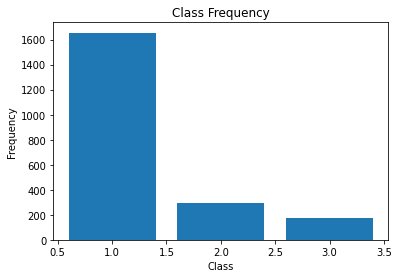

Relative Frequencies of each class in whole dataset:
1.0    0.778457
2.0    0.138758
3.0    0.082785
Name: fetal_health, dtype: float64


In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

data = pd.read_csv('data/fetal_health-1.csv')
N = len(data['fetal_health']) # Data set size

unique, counts = np.unique(data.iloc[:,-1], return_counts=True)
#print(unique, counts)
plt.bar(unique, counts)

plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

print('Relative Frequencies of each class in whole dataset:')
print(data['fetal_health'].value_counts()/N)

#print(data.describe())

#### Frequency of Each class (1,2,3) respectively
1 -> 1655 (78%)

2 -> 295 (14%)

3 -> 176 (8%)

### Now it is obvious the dataset is imbalanced and heavily leans toward Normal Outputs (1)
We can use stratification to remedy this.


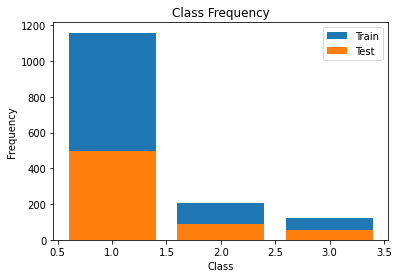

Relative Frequencies of each class in train set:
1.0    0.778226
2.0    0.139113
3.0    0.082661
Name: fetal_health, dtype: float64
Relative Frequencies of each class in test set:
1.0    0.778997
2.0    0.137931
3.0    0.083072
Name: fetal_health, dtype: float64


In [23]:
#Split data into train and test straifying on the fetal health
train_data, test_data = train_test_split(data,test_size=0.3, stratify=data['fetal_health'])

#Plot Frequencies
unique, counts = np.unique(train_data.iloc[:,-1], return_counts=True)
#print(unique, counts)
plt.bar(unique, counts)

unique, counts = np.unique(test_data.iloc[:,-1], return_counts=True)
#print(unique, counts)
plt.bar(unique, counts)

plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.legend(['Train','Test'])
plt.show()

print('Relative Frequencies of each class in train set:')
print(train_data['fetal_health'].value_counts()/len(train_data['fetal_health']))

print('Relative Frequencies of each class in test set:')
print(test_data['fetal_health'].value_counts()/len(test_data['fetal_health']))

## Result
Now that we used the stratify parameter, our test and training split has consistent amount of data relative to the global percentages.


# 10 Features most reflective of fetal health

## Method
We decided to use pearson correlation to do this. The closer the absolute value of the output is to 1, the stronger the correlation.

In the code, we took the last row of data which is gives me the correlation of everything with fetal_health.


In [14]:
corr_table = data.corr()
fh_corr = corr_table.iloc[-1,:].abs().sort_values(ascending=False).to_frame()
best_attrib = fh_corr.index.values[1:11]
#Print Top 10 attributes
print(best_attrib)


['prolongued_decelerations' 'abnormal_short_term_variability'
 'percentage_of_time_with_abnormal_long_term_variability' 'accelerations'
 'histogram_mode' 'histogram_mean' 'mean_value_of_long_term_variability'
 'histogram_variance' 'histogram_median' 'uterine_contractions']


## Result
As a result of pearson correlation, we found the set above to be the most highly correlated to
fetal healt.

# Significance Testing
We now will test if these attributes are not just randomly significant in our sample.

We will use both 0.05 and 0.1 as our significance values.

### Assumption
We are currently assuming the attributes are independent.

In [19]:
from scipy.stats import ttest_ind

sig_levels = (0.05,0.1)

significance_test = {}
#Last tuple in dict, will contain the results of the hypothesis testing, If True we reject the null hypothesis.
for attrib in best_attrib:
    t_score,p_score = ttest_ind(data[attrib],data['fetal_health'])
    significance_test[attrib] = (t_score,p_score,p_score<=sig_levels)
    print(significance_test[attrib][2])
#print(significance_test)

[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]


## Result
We can now see that for all 10 attributes, they are statistically significant on both critical values.



# Model Development
We will now create 2 models, a linear regression model and a naive bayes model.

In [47]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

#Convert from continous values to class values
def reg_to_class(pred):
    tmp = [ round(x) for x in pred ]
    for i in range(len(tmp)):
        if tmp[i] < 1.0:
            tmp[i] = 1.0
        elif tmp[i]>3.0:
            tmp[i] = 3.0
    return tmp

#split up train data
train_x = train_data.iloc[:,:-1]
train_y = train_data.iloc[:,-1]

#split up test data
test_x = test_data.iloc[:,:-1]
test_y = test_data.iloc[:,-1]

# Naive Bayes
NB_model = GaussianNB().fit(train_x,train_y)
NB_pred = NB_model.predict(test_x)
print(accuracy_score(NB_pred,test_y))

#Linear Regression
LR_model = LinearRegression().fit(train_x,train_y)
LR_pred = LR_model.predict(test_x)
LR_pred_classes = reg_to_class(LR_pred)

print(accuracy_score(LR_pred_classes,test_y))

0.8072100313479624
0.8275862068965517


## Code Overview
Up above, we created linear regression and naive bayes models for our data.


#### Here we are defining a helper function we found online

In [60]:
#function found online for multi-class confusion
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Metrics

Below we will show the confusion matrices, ROC curve, F1 score, and P-R curve for both models

## Naive Bayes

Confusion matrix, without normalization
F1:  [0.92150866 0.53744493 0.44117647]


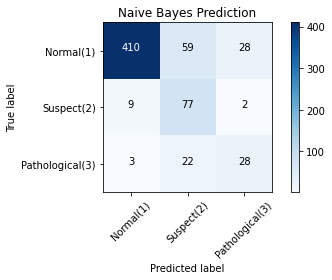

In [76]:
from sklearn.metrics import confusion_matrix,roc_auc_score, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve

cm = confusion_matrix(test_y, NB_pred,labels=[1.0,2.0,3.0])

plot_confusion_matrix(cm,classes=['Normal(1)','Suspect(2)','Pathological(3)'],title='Naive Bayes Prediction')

roc_score = roc_auc_score(trans_y,NB_model.predict_proba(test_x),multi_class='ovr')
print('F1: ', f1_score(test_y,NB_pred,average=None,zero_division=0))